## Import

In [1]:
import scipy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score

In [7]:
from tqdm import tqdm

In [6]:
import scipy
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import ast
SEED = 1234

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
#import xgboost as xgb
from joblib import dump, load

In [8]:
from sklearn.ensemble import RandomForestRegressor
#import lightgbm as lgb
#import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Function visual 

In [9]:
def vis_data(data,list_sensor,nsample):
    '''
    list_sensor: name of columns to visualize
    nsample: number of  ensembles data.
    '''
    start = data.id.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(20,3))
        plt.title(x)
        
        for i in range(start,start+nsample):
            plt.plot(data[data.id == i].time, data[data.id == i][x])
        plt.show()

## Data preparation

In [10]:
degradationData = pd.read_csv('train_FD002.txt', sep=' ', header=None,
                  names=['op_setting_1','op_setting_2','op_setting_3',
                        'sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10',
                        'sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21','sensor_22','sensor_23'])

degradationData.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 53759 entries, (1, 1) to (260, 316)
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   op_setting_1  53759 non-null  float64
 1   op_setting_2  53759 non-null  float64
 2   op_setting_3  53759 non-null  float64
 3   sensor_1      53759 non-null  float64
 4   sensor_2      53759 non-null  float64
 5   sensor_3      53759 non-null  float64
 6   sensor_4      53759 non-null  float64
 7   sensor_5      53759 non-null  float64
 8   sensor_6      53759 non-null  float64
 9   sensor_7      53759 non-null  float64
 10  sensor_8      53759 non-null  float64
 11  sensor_9      53759 non-null  float64
 12  sensor_10     53759 non-null  float64
 13  sensor_11     53759 non-null  float64
 14  sensor_12     53759 non-null  float64
 15  sensor_13     53759 non-null  float64
 16  sensor_14     53759 non-null  float64
 17  sensor_15     53759 non-null  float64
 18  sensor_16     53

In [11]:
## train
degradationData.drop(['sensor_22','sensor_23'], axis=1, inplace=True)
degradationData.reset_index(inplace=True)
degradationData.rename(columns={'level_0':'Unit', 'level_1':'Timestep'}, inplace=True)
degradationData.head()

,Unit,Timestep,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## Spit data

In [12]:
trainData = degradationData[degradationData.Unit <= 175].copy()
validationData = degradationData[degradationData.Unit > 175].copy()
trainData.Unit.nunique(), validationData.Unit.nunique()

(175, 85)

In [13]:
varNames = degradationData.columns.values
timeVariable = varNames[1]
conditionVariables = varNames[2:5]
dataVariables = varNames[5:]
timeVariable, conditionVariables, dataVariables

('Timestep',
 array(['op_setting_1', 'op_setting_2', 'op_setting_3'], dtype=object),
 array(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
        'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
        'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
        'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
        'sensor_21'], dtype=object))

In [14]:
conditionVariables

array(['op_setting_1', 'op_setting_2', 'op_setting_3'], dtype=object)

## Plot Range value of train data

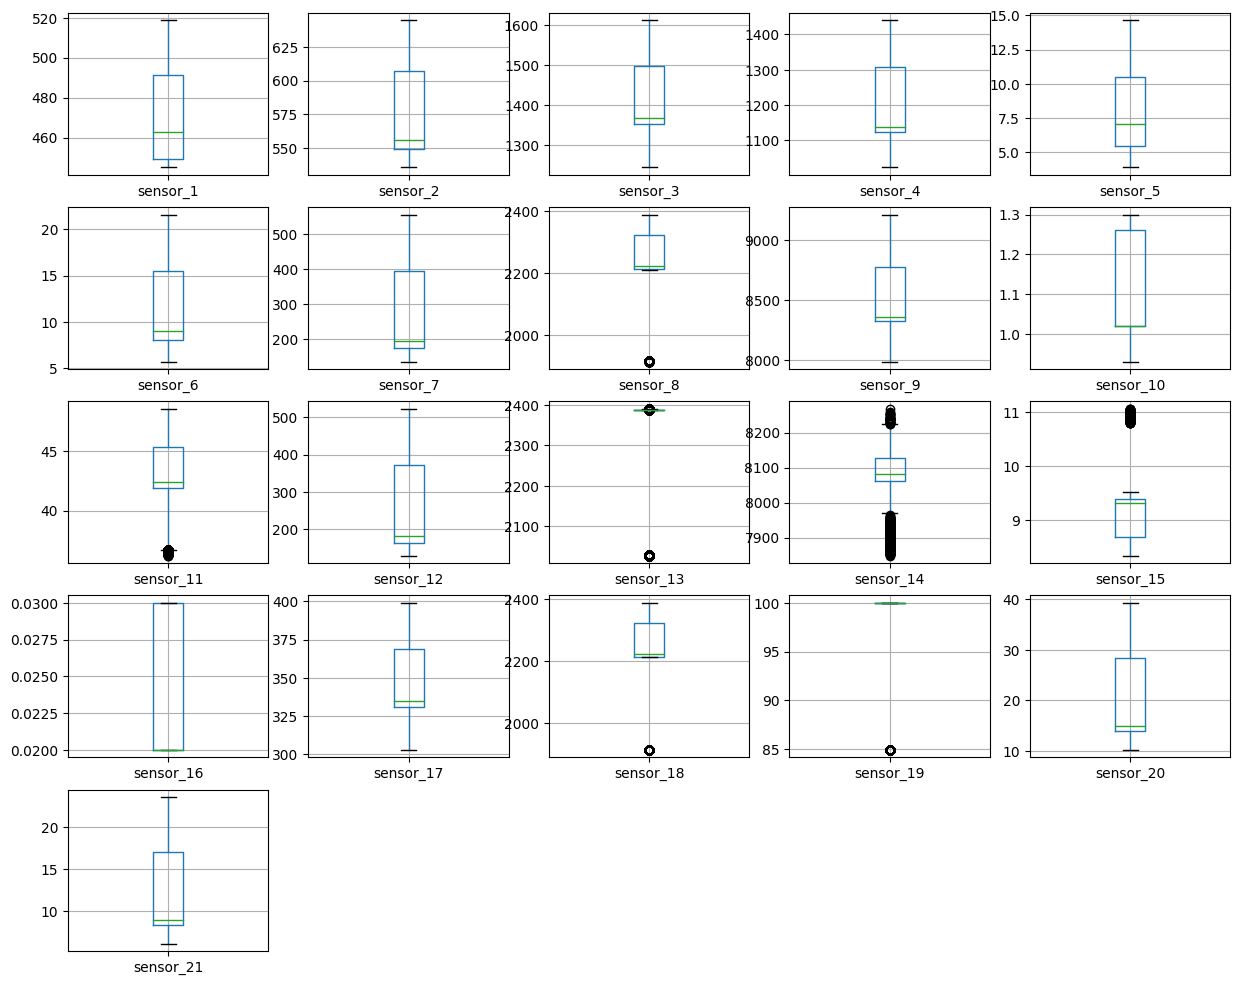

In [23]:
plt.figure(figsize=(15,50))
for i, col in enumerate(dataVariables):
    data_colums = trainData[col].copy().reset_index(drop=True)    
    plt.subplot(20, 5, i+1)
    data_colums.to_frame().boxplot()

## Normalize data

### Clustering

In [15]:
opCondition = trainData[conditionVariables] # get operating conditions

In [16]:
model_kmeans = KMeans(n_clusters=6, n_init=10,random_state = 0)
model_kmeans.fit(opCondition)
y_means = model_kmeans.predict(opCondition)

In [17]:
# save model kmeans
dump(model_kmeans,'model_kmeans.joblib')

['model_kmeans.joblib']

In [18]:
trainData['cluster'] = y_means
opCondition['cluster'] = y_means

### Create model Normalize

In [19]:
def regimeNormalization(data):
    list_df = []
    Clusters = data.cluster.unique()
    for cluster in Clusters:
        each_cluster = data[data.cluster == cluster].copy()
        sc = StandardScaler()
        each_cluster.loc[:, dataVariables] = sc.fit_transform(each_cluster.loc[:,dataVariables])
        sc_model = f'sc_model_{cluster}.joblib'
        dump(sc, sc_model)
        list_df.append(each_cluster)
    res_df = pd.concat(list_df)
    res_df.sort_values(by = ['Unit','Timestep'], inplace=True)
    return res_df

In [20]:
## Gen model Normalize
trainDataNormalized = regimeNormalization(trainData)
trainDataNormalized.head()

,Unit,Timestep,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,cluster
0,1,1,34.9983,0.8400,100.0,0.0,-1.049946,-1.398221,0.789186,-8.881784e-16,...,-1.450350,-1.588766,0.389890,6.938894e-18,-0.138999,0.0,0.000000e+00,-0.909782,-1.360990,5
1,1,2,41.9982,0.8408,100.0,0.0,0.464414,-0.194127,-0.228321,1.776357e-15,...,-1.274089,-1.091773,0.102630,0.000000e+00,-0.730790,0.0,0.000000e+00,-1.639366,-1.331787,0
2,1,3,24.9988,0.6218,60.0,0.0,1.264393,-1.098780,-0.391473,1.776357e-15,...,-1.062959,-1.074863,-0.426332,3.469447e-18,1.313241,0.0,-1.421085e-14,-1.658612,1.708013,2
3,1,4,42.0077,0.8416,100.0,0.0,-0.427205,-0.051374,-0.150028,1.776357e-15,...,-1.432980,-1.319209,-0.543066,0.000000e+00,-1.437750,0.0,0.000000e+00,0.018773,1.830378,0
4,1,5,25.0005,0.6203,60.0,0.0,0.593379,-0.919418,-0.321444,1.776357e-15,...,-1.171634,-1.355113,-0.375318,3.469447e-18,1.313241,0.0,-1.421085e-14,-1.210646,-0.474588,2


### Plot range each sensor of machine

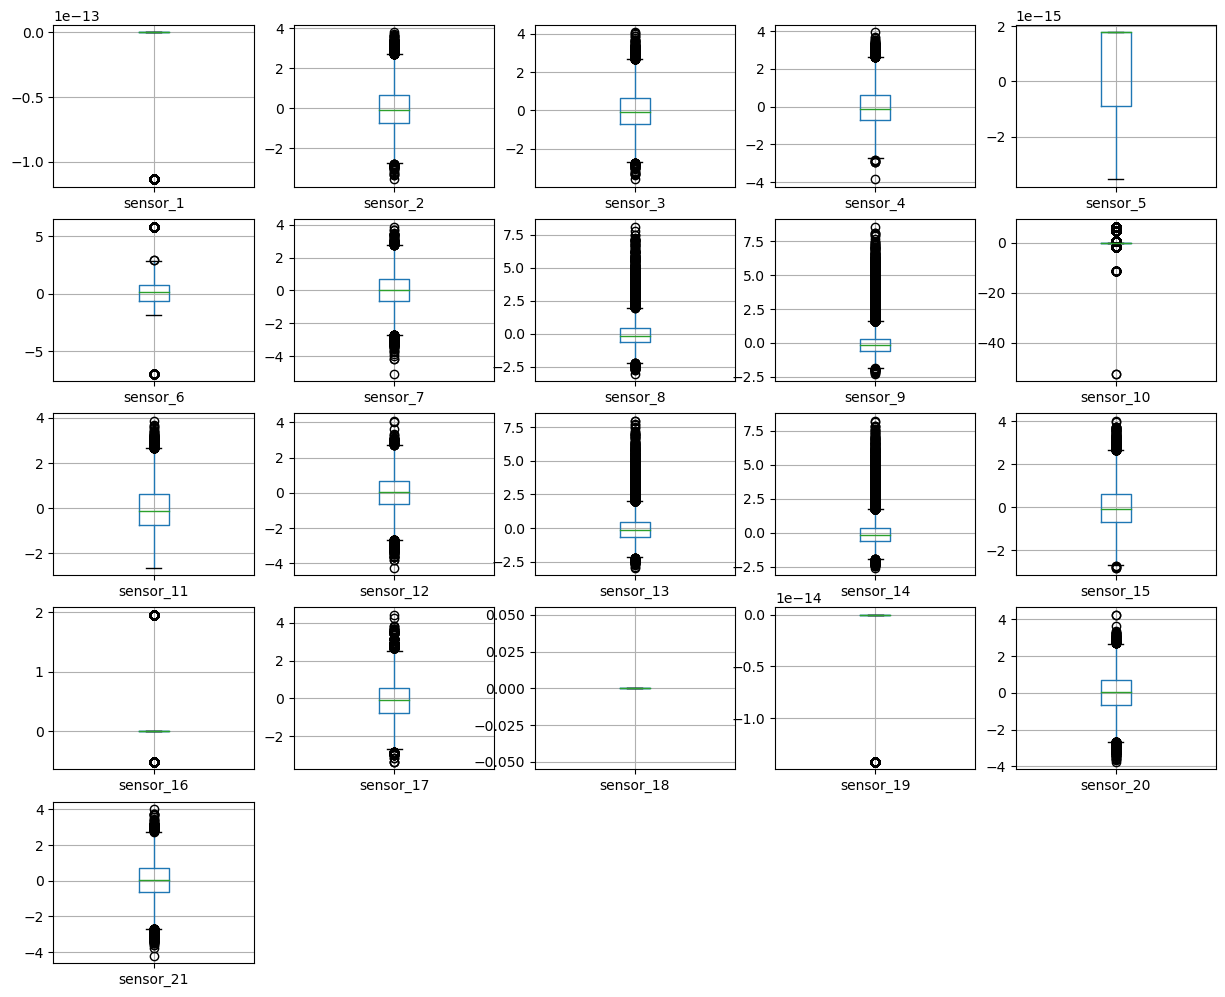

In [21]:
plt.figure(figsize=(15,50))
for i, col in enumerate(dataVariables):
    
    data_colums = trainDataNormalized[col].copy().reset_index(drop=True)
    
    #processed_asset = processed_data.query(f'set_AssetId == "{asset_id}"').copy().reset_index(drop=True)
    
    plt.subplot(20, 5, i+1)
    data_colums.to_frame().boxplot()

### Normalize data for test

In [22]:
def load_Normalization(data):
    list_df = []
    Clusters = data.cluster.unique()
    for cluster in Clusters:
        each_cluster = data[data.cluster == cluster].copy()
        sc_model = f'sc_model_{cluster}.joblib'
        sc = load(sc_model)
        each_cluster.loc[:, dataVariables] = sc.transform(each_cluster.loc[:,dataVariables])
        list_df.append(each_cluster)
    res_df = pd.concat(list_df)
    res_df.sort_values(by = ['Unit','Timestep'], inplace=True)
    return res_df


## Create health indicator

In [23]:
# make head indicator
units = trainDataNormalized.Unit.unique()
list_df = []
for unit in units:
    each_unit = trainDataNormalized[trainDataNormalized.Unit == unit].copy()
    rul = len(each_unit)
    each_unit['health'] = each_unit.apply(lambda x: (1 - (x.Timestep*1.0/rul)) , axis=1)
    list_df.append(each_unit)
trainDataNormalized = pd.concat(list_df)
trainDataNormalized.head()

,Unit,Timestep,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,cluster,health
0,1,1,34.9983,0.8400,100.0,0.0,-1.049946,-1.398221,0.789186,-8.881784e-16,...,-1.588766,0.389890,6.938894e-18,-0.138999,0.0,0.000000e+00,-0.909782,-1.360990,5,0.993289
1,1,2,41.9982,0.8408,100.0,0.0,0.464414,-0.194127,-0.228321,1.776357e-15,...,-1.091773,0.102630,0.000000e+00,-0.730790,0.0,0.000000e+00,-1.639366,-1.331787,0,0.986577
2,1,3,24.9988,0.6218,60.0,0.0,1.264393,-1.098780,-0.391473,1.776357e-15,...,-1.074863,-0.426332,3.469447e-18,1.313241,0.0,-1.421085e-14,-1.658612,1.708013,2,0.979866
3,1,4,42.0077,0.8416,100.0,0.0,-0.427205,-0.051374,-0.150028,1.776357e-15,...,-1.319209,-0.543066,0.000000e+00,-1.437750,0.0,0.000000e+00,0.018773,1.830378,0,0.973154
4,1,5,25.0005,0.6203,60.0,0.0,0.593379,-0.919418,-0.321444,1.776357e-15,...,-1.355113,-0.375318,3.469447e-18,1.313241,0.0,-1.421085e-14,-1.210646,-0.474588,2,0.966443


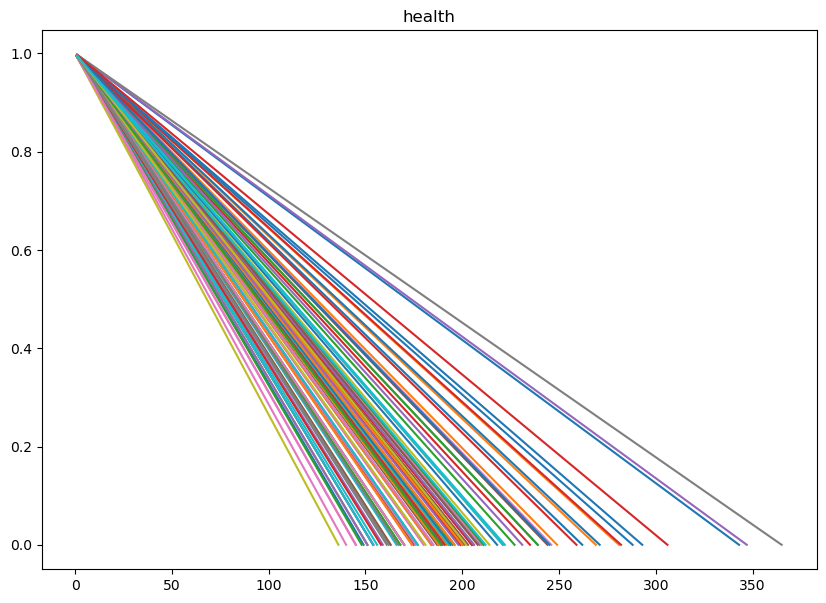

In [24]:
def vis_ensemble(data,list_sensor,nsample):
    start = data.Unit.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(10,7))
        plt.title(x)
        for i in range(start,start+nsample):
            plt.plot(data[data.Unit== i].Timestep, data[data.Unit == i][x])
        plt.show()
vis_ensemble(trainDataNormalized,['health'],100)

## Choose feature

In [25]:
sensorToFuse = ['sensor_2','sensor_3','sensor_4','sensor_7','sensor_11','sensor_12','sensor_15','sensor_17'] 
X = trainDataNormalized[sensorToFuse]
y = trainDataNormalized.health
regModel = LinearRegression()
regModel.fit(X,y)
weights = regModel.coef_
weights

array([-0.03144579, -0.02900143, -0.05151199,  0.00572367, -0.06626844,
        0.00568951, -0.04490592, -0.03622847])

In [26]:
## Save model 
with open('weights.npy','wb') as f:
    np.save(f, weights)

In [46]:
def degradationSensorFusion(data, sensorToFuse, weights):
    smooth_health_indicator = pd.DataFrame(data = np.sum(data[sensorToFuse]*weights, axis=1), columns = ['smooth_health_indicator'])
    smooth_health_indicator[['Unit','Timestep']] = data[['Unit','Timestep']].copy()
    units = smooth_health_indicator.Unit.unique()
    list_df = []
    for unit in units:
        each_unit = smooth_health_indicator[smooth_health_indicator.Unit == unit].copy()
        each_unit['smooth_health_indicator'] = each_unit['smooth_health_indicator'].rolling(window=21, center=True, min_periods=0).mean()
        neg = each_unit['smooth_health_indicator'].values[0]
        each_unit['smooth_health_indicator'] = each_unit['smooth_health_indicator'] + 1 - neg
        list_df.append(each_unit)
    res_df = pd.concat(list_df)
    return res_df
trainDataFused = degradationSensorFusion(trainDataNormalized, sensorToFuse, weights)

In [48]:
trainDataFused

,smooth_health_indicator,Unit,Timestep
0,1.000000,1,1
1,1.011429,1,2
2,1.008740,1,3
3,1.011609,1,4
4,1.018202,1,5
...,...,...,...
36603,0.233895,175,198
36604,0.228962,175,199
36605,0.212173,175,200
36606,0.197490,175,201


In [49]:
trainDataFused.to_csv('trainDataFused.csv', index=False)

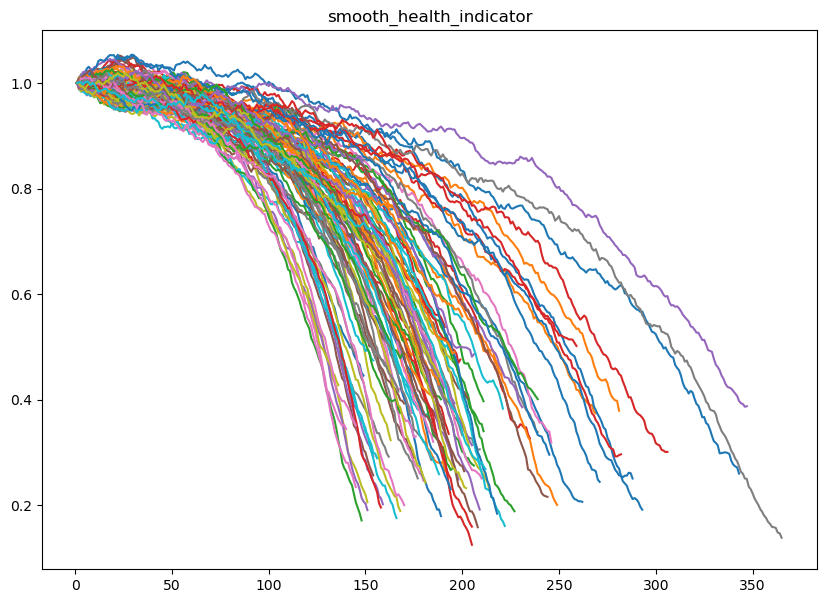

In [30]:
vis_ensemble(trainDataFused,['smooth_health_indicator'],100)

## Apply same operation to validation data

In [29]:
#validationData.to_csv("all_test.csv", index=False)

In [50]:
#P redict columns for validation data
opCondition_var = validationData[conditionVariables]
y_means_var = model_kmeans.predict(opCondition_var)
validationData['cluster'] = y_means_var ## Create cruster

In [51]:
validationData

,Unit,Timestep,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,cluster
36608,176,1,42.0003,0.8400,100.0,445.00,549.37,1345.94,1128.55,3.91,...,2387.95,8082.22,9.3796,0.02,331,2212,100.00,10.76,6.3382,0
36609,176,2,0.0021,0.0000,100.0,518.67,642.25,1583.77,1402.43,14.62,...,2388.12,8138.43,8.4156,0.03,394,2388,100.00,39.06,23.3051,3
36610,176,3,25.0002,0.6212,60.0,462.54,537.03,1265.74,1043.04,7.05,...,2028.26,7874.99,10.8821,0.02,306,1915,84.93,14.41,8.7017,2
36611,176,4,41.9994,0.8400,100.0,445.00,549.93,1350.62,1131.21,3.91,...,2387.97,8090.01,9.3628,0.02,330,2212,100.00,10.49,6.2807,0
36612,176,5,34.9998,0.8400,100.0,449.44,555.71,1371.53,1130.00,5.48,...,2388.04,8071.90,9.2974,0.02,334,2223,100.00,14.82,8.9769,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,491.19,608.79,1495.60,1269.51,9.35,...,2389.02,8169.64,9.3035,0.03,369,2324,100.00,24.36,14.5189,1
53755,260,313,10.0022,0.2510,100.0,489.05,605.81,1514.32,1324.12,10.52,...,2388.42,8245.36,8.7586,0.03,374,2319,100.00,28.10,16.9454,4
53756,260,314,25.0041,0.6200,60.0,462.54,537.48,1276.24,1057.92,7.05,...,2030.33,7971.25,11.0657,0.02,310,1915,84.93,14.19,8.5503,2
53757,260,315,25.0033,0.6220,60.0,462.54,537.84,1272.95,1066.30,7.05,...,2030.35,7972.47,11.0537,0.02,311,1915,84.93,14.05,8.3729,2


In [52]:
validationDataNormalized = load_Normalization(validationData)

In [53]:
validationDataNormalized[validationDataNormalized.Timestep == 1]

,Unit,Timestep,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,cluster
36608,176,1,42.0003,0.8400,100.0,0.000000e+00,-0.747273,-1.477145,0.133131,1.776357e-15,...,-0.352520,-0.471948,0.160375,0.000000e+00,-0.023831,0.0,0.0,1.584792,-0.218196,0
36772,177,1,10.0011,0.2500,100.0,-1.136868e-13,0.273103,-0.059820,-0.335082,1.776357e-15,...,0.227943,-0.844183,0.259171,-3.469447e-18,-0.439049,0.0,0.0,1.025137,0.385205,4
36953,178,1,42.0020,0.8400,100.0,0.000000e+00,-0.792997,-1.952989,-0.872931,1.776357e-15,...,-0.670303,-0.746870,-0.256965,0.000000e+00,-0.730790,0.0,0.0,-1.639366,0.940436,0
37101,179,1,35.0061,0.8400,100.0,0.000000e+00,-0.801255,-0.081939,-0.040531,-8.881784e-16,...,-1.313816,-1.029913,0.202436,6.938894e-18,-0.138999,0.0,0.0,-0.734698,-0.328063,5
37282,180,1,0.0027,0.0000,100.0,0.000000e+00,-1.492319,-1.056890,-1.449745,-3.552714e-15,...,-1.335028,-0.236211,-0.494585,-6.938894e-18,-1.395951,0.0,0.0,1.429583,1.928749,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52623,256,1,20.0051,0.7000,100.0,0.000000e+00,-0.636468,-0.397820,-1.242447,1.776357e-15,...,-0.336058,-0.607119,0.454451,-5.119298e-01,-1.574406,0.0,0.0,0.668214,0.045357,1
52786,257,1,10.0039,0.2514,100.0,-1.136868e-13,-0.649378,-0.880214,-0.411092,1.776357e-15,...,-1.609339,-0.743285,-0.444132,-3.469447e-18,-1.781357,0.0,0.0,0.064395,1.048256,4
53095,258,1,35.0073,0.8400,100.0,0.000000e+00,0.216119,0.102340,-0.144412,-8.881784e-16,...,-1.347950,-1.580148,0.425840,6.938894e-18,-0.138999,0.0,0.0,-1.084866,-0.690623,5
53238,259,1,35.0064,0.8400,100.0,0.000000e+00,-1.479504,-0.794487,-0.135090,-8.881784e-16,...,-0.119140,-0.073299,-1.810766,6.938894e-18,-0.138999,0.0,0.0,0.578433,-1.144933,5


In [54]:
validataionDataToFused = degradationSensorFusion(validationDataNormalized, sensorToFuse, weights)

In [55]:
validataionDataToFused

,smooth_health_indicator,Unit,Timestep
36608,1.000000,176,1
36609,0.999033,176,2
36610,0.996910,176,3
36611,0.990334,176,4
36612,0.986447,176,5
...,...,...,...
53754,0.216703,260,312
53755,0.209915,260,313
53756,0.209766,260,314
53757,0.199929,260,315


## RUL similarity

In [37]:
validataionDataToFused.rename(columns={'Timestep':'Time'}, inplace=True)
trainDataFused.rename(columns={'Timestep':'Time'}, inplace=True)

In [38]:
def estimate_rul(selected_units, train_data, sample_len):
    """
    This function estimate RUL of a period given its neighbors RUL info
    Params:
        selected_units (list): neighbor units from training data
        train_data (DataFrame): training data
        sample_len (int): current lifetime value of val sample
    Return:
        predict_RUL (int): estimated RUL 
    """

    # get distribution of next RUL values for each neighbors
    selected_data = train_data[train_data.Unit.isin(selected_units)]
    distributions = selected_data.groupby('Unit').size()
    distributions = pd.Series(distributions)
    
    try:
        ax = distributions.plot(kind='kde', figsize=(10, 5))
        # get distribution values
        hist_x = ax.lines[0]._x
        hist_y = ax.lines[0]._y

        # calculate median of distribution
        cdf = scipy.integrate.cumtrapz(hist_y, hist_x, initial=0)
        nearest_05 = np.abs(cdf - 0.5).argmin()

        x_median = hist_x[nearest_05]
        predict_RUL = max(0, x_median - sample_len)  # predicted value 

    except Exception as e:
        print(e)
        predict_RUL = 0
    plt.close()  # add this so plot wont show up
    return predict_RUL

In [39]:
def fit_polyline(train_data, polynomial_deg):
    """
    This function return fitted polynomial line for each training data period
    Params:
        train_data (DataFrame): train data with smoothed health indicator value
        polynomial_deg (int): degree of polynominal curve
    Return:
        reg_model_lib (dict): fit line for each unit in train data
    """
    
    # fit polynominal line to health-indicator lines
    reg_model_lib = dict()
    vis_loss = []
    for unit in train_data['Unit'].unique():
        # get each unit data
        unit_data = train_data[train_data['Unit'] == unit]
        unit_data.reset_index(drop=True, inplace=True)

        # convert to polynomial feature 
        X_poly = unit_data.Time
        y_poly = unit_data['smooth_health_indicator']

        poly = PolynomialFeatures(degree=polynomial_deg)
        X_poly = poly.fit_transform(X_poly.values.reshape(-1, 1))

        # fit poly line
        clf = LinearRegression()
        clf.fit(X_poly, y_poly)

        # save unit line to query dict
        reg_model_lib[unit] = clf
    return reg_model_lib

In [40]:
def scoring(train_data, unit_sample, reg_model_lib, sample_len, polynomial_deg=7):
    """
    This function calculate similarity score for each reg_model to 
    query sample
    Params:
        train_data (DataFrame): training data
        unit_sample (DataFrame): query unit to calculate similarity score
        reg_model_lib (dict): linear model of each training unit
        polynomial_deg (int): degree of polynomial line
    Return:
        scores_dict (dict): similarity score of each training unit to query unit
    """

    scores_dict = dict()

    # transform time steps (cycle) to polynomial feature 
    poly = PolynomialFeatures(polynomial_deg)
    time_steps = poly.fit_transform(np.arange(1, sample_len+1).reshape(-1, 1))

    for unit, reg_model in reg_model_lib.items():
        train_unit = train_data[train_data['Unit'] == unit]
        if len(train_unit) < sample_len:
            continue

        # get line of each neighbor
        current_line = reg_model.predict(time_steps)

        # calculate distance between each line and get similarity score
        distance = np.linalg.norm((unit_sample.iloc[:sample_len]['smooth_health_indicator'] - current_line), ord=1)
        sim_score = np.exp(-distance ** 2)

        scores_dict[unit] = sim_score
    return scores_dict

In [41]:
def scoring_linear_reg(train_data, unit_sample, reg_model_lib, sample_len, polynomial_deg=7):
    """
    This function calculate similarity score for each reg_model to 
    query sample
    Params:
        train_data (DataFrame): training data
        unit_sample (DataFrame): query unit to calculate similarity score
        reg_model_lib (dict): linear model of each training unit
        polynomial_deg (int): degree of polynomial line
    Return:
        scores_dict (dict): similarity score of each training unit to query unit
    """

    scores_dict = dict()

    # transform time steps (cycle) to polynomial feature 
    poly = PolynomialFeatures(polynomial_deg)
    time_steps = poly.fit_transform(np.arange(1, sample_len+1).reshape(-1, 1))
    time_steps = pd.DataFrame(time_steps)
    
    # select units with valid length only
    train_unit_sizes = train_data.groupby('Unit').size()
    pred_units = train_unit_sizes[train_unit_sizes >= sample_len].index.values

    # convert dict of reg models to dataframe
    model_params = []
    for unit in pred_units:
        reg_model = reg_model_lib[unit]
        model_params.append(reg_model.coef_.tolist() + [reg_model.intercept_]+[unit])
    model_params = pd.DataFrame(model_params)
    
    # renaming 
    model_params.rename(columns={model_params.columns[-1]: "Unit",
                                 model_params.columns[-2]: "intercept"},
                        inplace = True)
    
    # calculate distance and similarity score
    neighbors_line = time_steps.dot(model_params.iloc[:, :-2].T) + model_params['intercept']
    distance = unit_sample.iloc[:sample_len]['smooth_health_indicator'].values - neighbors_line.T
    distance['Unit'] = model_params['Unit'].copy()
    distance['sim_score'] = np.exp(-np.linalg.norm(distance.T.iloc[:-1, :], ord=1, axis=0) ** 2)
    scores_dict = distance[['Unit', 'sim_score']].set_index('Unit')['sim_score'].to_dict()
    return scores_dict

In [42]:
def predict_days(train_data, val_fused_data, cutpoint, reg_model_lib, hours=24, break_point=0, model='linear', NEIGHBORS_NUM=50, polynomial_deg=7):
    """
    This function return loss of a query sample predicted RUL from its neighbors
    Params:
        train_data (DataFrame): train data
        val_fused_data (DataFrame): validation data
        cutpoint (float): percentage of sample length to query
        reg_model_lib (dict): linear model of each training unit
        hours (int): number of hours data
        break_point (int): number of input observations to estimate RUL, this != 0 will ignore cutpoint
        NEIGHBORS_NUM (int): Numbers of neighbor to estimate RUL
        polynomial_deg (int): polynomial degree 
    Return:
        losses (list): loss value list of each query sample
    """

    losses = []
    labels = []
    predict_results = []
    day_rate = 24/hours
    
    # go through each query unit
    for unit in val_fused_data['Unit'].unique():
        unit_sample = val_fused_data[val_fused_data['Unit'] == unit][['Time', 'smooth_health_indicator']]

        true_RUL_point = int(len(unit_sample) * cutpoint)
        
        if break_point != 0:
            true_RUL_point = break_point

        true_RUL = len(unit_sample) - true_RUL_point
        true_RUL /= day_rate
        
        if model == 'linear':
            scores_dict = scoring_linear_reg(train_data, unit_sample, reg_model_lib, sample_len=true_RUL_point, polynomial_deg=polynomial_deg)
        else:
            scores_dict = scoring(train_data, unit_sample, reg_model_lib, sample_len=true_RUL_point, polynomial_deg=polynomial_deg)

        # sort similarity score asc
        sorted_scores = dict(sorted(scores_dict.items(), key=lambda item: item[1], reverse=True))
        selected_units = list(sorted_scores.keys())[:NEIGHBORS_NUM]  # get top nearest neighbors

        predict_RUL = estimate_rul(selected_units, train_data, true_RUL_point)
        predict_RUL /= day_rate

        losses.append(abs(predict_RUL - true_RUL))
        labels.append(true_RUL)
        predict_results.append(predict_RUL)

    return losses, labels, predict_results

In [43]:
def get_loss_days(train_data, val_fused_data, reg_model_lib, polynomial_deg, NEIGHBORS_NUM, hours=24):
    """
    This function return experimental loss of current modeled health-indicator line.
    The result consists of different losses from 3 input sequence lengths - 50%, 70% and 90% length of input
    Params:
        train_data (DataFrame): train data
        val_fused_data (DataFrame): validation data
        hours (int): numbers of period hours
        reg_model_lib (dict): linear model of each training unit
        polynomial_deg (int): polynomial degree of modeled health-indicator
    Return:
        loss_df (DataFrame): loss value list of each query sample
    """
    
    # get losses
    loss_50, labels_50, pred_50 = predict_days(train_data, val_fused_data, 0.5, reg_model_lib, hours = hours, model='linear', break_point=0, NEIGHBORS_NUM=NEIGHBORS_NUM, polynomial_deg=polynomial_deg)
    loss_70, labels_70, pred_70 = predict_days(train_data, val_fused_data, 0.7, reg_model_lib, hours = hours, model='linear', break_point=0, NEIGHBORS_NUM=NEIGHBORS_NUM, polynomial_deg=polynomial_deg)
    loss_90, labels_90, pred_90 = predict_days(train_data, val_fused_data, 0.9, reg_model_lib, hours = hours, model='linear', break_point=0, NEIGHBORS_NUM=NEIGHBORS_NUM, polynomial_deg=polynomial_deg)

    loss_df = pd.DataFrame()
    loss_df['True RUL 50'] = labels_50
    loss_df['Pred RUL 50'] = pred_50
    loss_df['Sample 50%'] = loss_50

    loss_df['True RUL 70'] = labels_70
    loss_df['Pred RUL 70'] = pred_70
    loss_df['Sample 70%'] = loss_70

    loss_df['True RUL 90'] = labels_90
    loss_df['Pred RUL 90'] = pred_90
    loss_df['Sample 90%'] = loss_90
    return loss_df

In [53]:
def evalutate_rul_regressor(train_fused_data, val_fused_data, hours=24, degree=4):
    # fit training health indicator line
    health_indicator = train_fused_data[['Unit', 'Time', 'smooth_health_indicator']].copy()
    reg_model_lib = fit_polyline(health_indicator, polynomial_deg=degree)
    
    # evaluate
    print('Start calculating loss')
    start_time = time.time()
    
    loss_df = get_loss_days(health_indicator, val_fused_data, reg_model_lib, degree, hours= hours, NEIGHBORS_NUM=10)
    end_time = time.time() - start_time
    print('Finished after: {} minutes'.format(end_time/60))
    return loss_df, reg_model_lib
loss_cols = ['Sample 50%', 'Sample 70%', 'Sample 90%']

In [54]:
loss_1day, reg_model_lib_1day = evalutate_rul_regressor(trainDataFused, validataionDataToFused, hours=24, degree=3)

Start calculating loss
Finished after: 0.17057993014653525 minutes


In [55]:
loss_1day[['Sample 50%','Sample 70%','Sample 90%']].mean()

Sample 50%    18.408379
Sample 70%    11.285109
Sample 90%     8.983366
dtype: float64

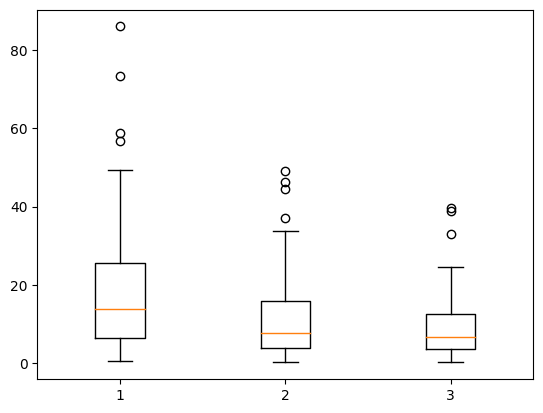

In [56]:
plt.boxplot(loss_1day[['Sample 50%','Sample 70%','Sample 90%']]);

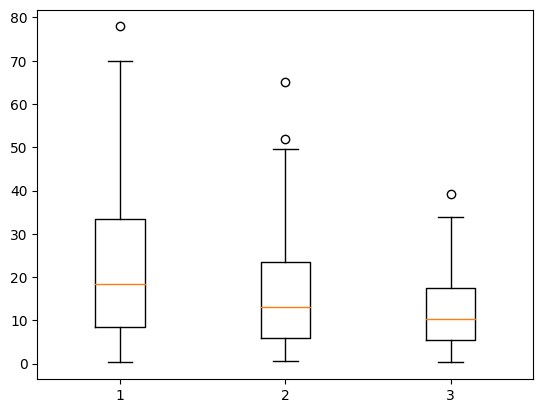

In [168]:
plt.boxplot(loss_1day[['Sample 50%','Sample 70%','Sample 90%']]);

In [169]:
loss_1day[['Sample 50%','Sample 70%','Sample 90%']].mean()

Sample 50%    22.544868
Sample 70%    15.908868
Sample 90%    12.570918
dtype: float64

In [170]:
loss_1day[['Sample 50%','Sample 70%','Sample 90%']].median()

Sample 50%    18.435435
Sample 70%    13.117117
Sample 90%    10.210210
dtype: float64

## Create the function predict day by day

In [59]:
def consecutive_predict_days(train_data, val_unit, reg_model_lib, hours=24, model='linear', min_day_predict=7, polynomial_deg=None, NEIGHBORS_NUM=50):
    """
    This function return prediction RUL of live data
    Params:
        train_data (DataFrame): train data
        val_unit (DataFrame): single-unit validation data
        reg_model_lib (dict): linear model of each training unit
        hours (int): numbers of period hours
        polynomial_deg (int): polynomial degree of modeled health-indicator
        NEIGHBORS_NUM (int): Numbers of neighbor to estimate RUL
    Return:
        losses (list): loss value list of each query sample
    """
    losses = []
    labels = []
    predict_results = []
    day_rate = 24/hours 
    min_day_predict *= day_rate
    
    # min_day_predict = 50 - need at least 50 running days to predict an error
    # go through each query unit
    for i in range(len(val_unit) - int(min_day_predict)):
        sample_len = int(min_day_predict + i)
        true_RUL = len(val_unit) - sample_len
        true_RUL /= day_rate
        
        if model == 'linear':
            scores_dict = scoring_linear_reg(train_data, val_unit.iloc[:sample_len], reg_model_lib, sample_len=sample_len, polynomial_deg=polynomial_deg)
        else:
            scores_dict = scoring(train_data, val_unit.iloc[:sample_len], reg_model_lib, sample_len=sample_len, polynomial_deg=polynomial_deg)

        # sort similarity score asc
        sorted_scores = dict(sorted(scores_dict.items(), key=lambda item: item[1]))
        selected_units = list(sorted_scores.keys())[:NEIGHBORS_NUM]  # get nearest neighbors

        predict_RUL = estimate_rul(selected_units, train_data, sample_len)
        predict_RUL /= day_rate 
        
        predict_results.append(predict_RUL)
        losses.append(abs(predict_RUL - true_RUL))
        labels.append(true_RUL)
        
    return losses, labels, predict_results

In [60]:
def evalutate_rul_regressor_consecutive(train_fused_data, val_fused_data, degree=4, hours = 24):
    print("start:")
    start_time = time.time()
    # fit training health indicator line
    health_indicator = train_fused_data[['Unit', 'Time', 'smooth_health_indicator']].copy()
    reg_model_lib = fit_polyline(health_indicator, polynomial_deg=degree)
    end_time = time.time() - start_time
    print('Finished after: {} minutes'.format(end_time/60))
    # evaluate
    print('Start calculating loss')
    start_time = time.time()
    
    loss_df = []
    label_df = []
    predict_df = []
    unit_df = []
    for unit in tqdm(val_fused_data.Unit.unique()):
        try:
            val_unit = val_fused_data[val_fused_data.Unit == unit].copy().reset_index(drop=True)
            losses, labels, predict_results = consecutive_predict_days(train_fused_data, val_unit, reg_model_lib,hours = hours,
                                                                  model='linear', min_day_predict=100, polynomial_deg=degree, NEIGHBORS_NUM=10)
            loss_df +=losses
            label_df +=labels
            predict_df +=  predict_results
            unit_df += ([unit]*len(losses))
        except:
            print("error unit: ", unit)
    end_time = time.time() - start_time
    print('Finished after: {} minutes'.format(end_time/60))
    
    ans = pd.DataFrame(columns = ['Unit','True', 'Predict','Loss'])
    ans['Unit'] = unit_df
    ans['True'] = label_df
    ans['Predict'] = predict_df
    ans['Loss'] = loss_df
    
    return ans

In [61]:
loss_neighbor = evalutate_rul_regressor_consecutive(trainDataFused, validataionDataToFused, degree=3)

start:
Finished after: 0.0019126494725545248 minutes
Start calculating loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [05:36<00:00,  3.96s/it]

Finished after: 5.61058783531189 minutes


In [166]:
loss_neighbor = evalutate_rul_regressor_consecutive(trainDataFused, validataionDataToFused, degree=3)

start:
Finished after: 0.0018446683883666993 minutes
Start calculating loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [09:20<00:00,  6.59s/it]

Finished after: 9.34032468398412 minutes


<Axes: ylabel='Count'>

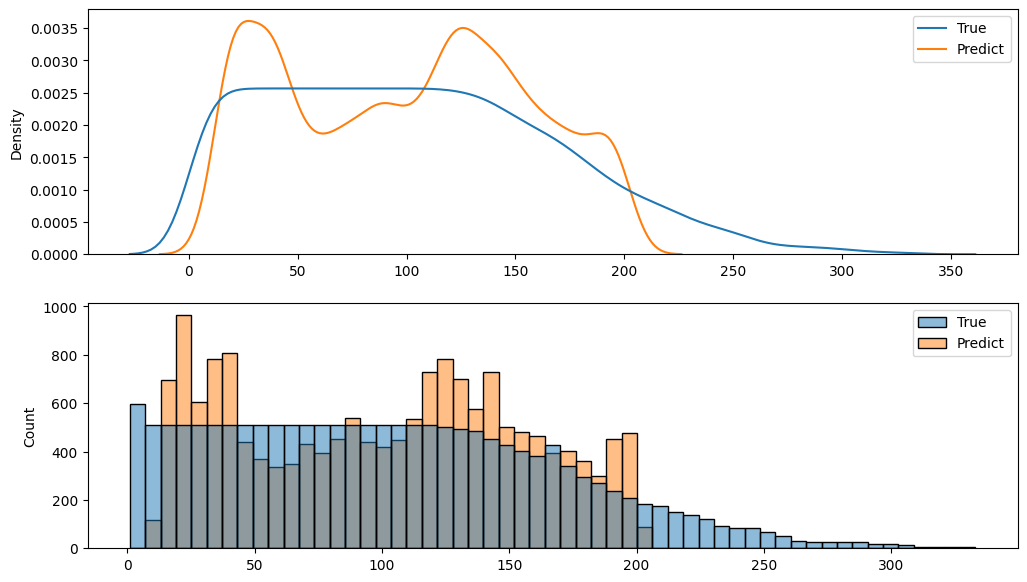

In [163]:
fig, axs = plt.subplots(2, figsize=(12,7))
sns.kdeplot(ax= axs[0], data=loss_neighbor_1days.loc[:, ['True','Predict']])
sns.histplot(ax = axs[1], data=loss_neighbor_1days.loc[:, ['True','Predict']])

<Axes: ylabel='Count'>

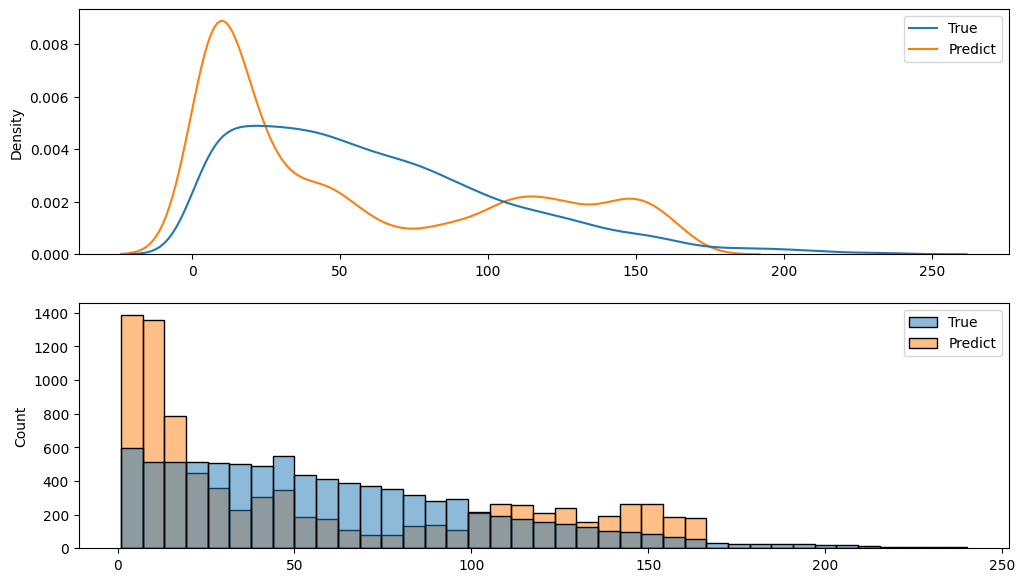

In [62]:
fig, axs = plt.subplots(2, figsize=(12,7))
sns.kdeplot(ax= axs[0], data=loss_neighbor.loc[:, ['True','Predict']])
sns.histplot(ax = axs[1], data=loss_neighbor.loc[:, ['True','Predict']])

In [ ]:
# Plot true and predicted RUL values
plt.figure(figsize=(20,7))
plt.plot(loss_org_data['True RUL 70'], label = "True RUL", color = "red")
plt.plot(loss_org_data['Pred RUL 70'], label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [133]:
def predict_continuously(data):
    """
    This function make columns 'observe'
    """
    def soc_iter(lst):
        i = 0
        lst_obs = []
        while i < len(lst):
            if lst[i] > 30:
                lst_obs += ['good'] * min(15, len(lst) - i)
                i += 15
            elif lst[i] > 15:
                lst_obs.append('observe')
                i += 1
            else:
                i += 1
                lst_obs.append('warning')
        return lst_obs


    df_unit = []
    for unit in data.Unit.unique():
        each_unit = data[data.Unit == unit].copy()
        each_unit['observe'] = soc_iter(each_unit.Predict.values)
        df_unit.append(each_unit)
    df_res = pd.concat(df_unit,ignore_index=True )
    return df_res


def make_score(data):
    data['true_values'] = data['True'].apply(lambda x: 0 if x <= 15 else 1)
    data['observe_values'] = data['observe'].apply(lambda x: 0 if x == 'warning' else 1)
    #print('Score of all points:',rand_score(data.true_values, data.observe_values))
    print('Score of all points:',accuracy_score(data.true_values, data.observe_values))
        
def make_score_warning(data):
    data['true_values'] = data['True'].apply(lambda x: 0 if x <= 15 else 1)
    data['observe_values'] = data['observe'].apply(lambda x: 0 if x == 'warning' else 1)
    df_warning = data[data.observe == 'warning'].copy()
    #print('Score of warning points:',rand_score(df_warning.true_values, df_warning.observe_values))
    print('Score of warning points:',accuracy_score(df_warning.true_values, df_warning.observe_values))

In [69]:
loss_neighbor = predict_continuously(loss_neighbor)
make_score(loss_neighbor)
make_score_warning(loss_neighbor)

Score of all points: 0.7744769390821871
Score of warning points: 0.0


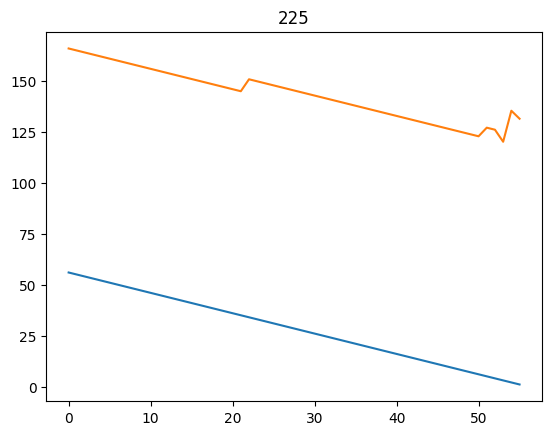

In [133]:
pred_unit = loss_neighbor[loss_neighbor.Unit == np.random.choice(loss_neighbor.Unit)].reset_index(drop=True)
plt.title(pred_unit.Unit.unique()[0])
plt.plot(pred_unit['True'])
plt.plot(pred_unit['Predict']);

## Calculator mean squared error polynomial features

In [103]:
health_indicator = trainDataFused[['Unit', 'Time', 'smooth_health_indicator']]
unit_sample = validataionDataToFused[validataionDataToFused.Unit == np.random.choice(validataionDataToFused.Unit)][['Time', 'smooth_health_indicator']]

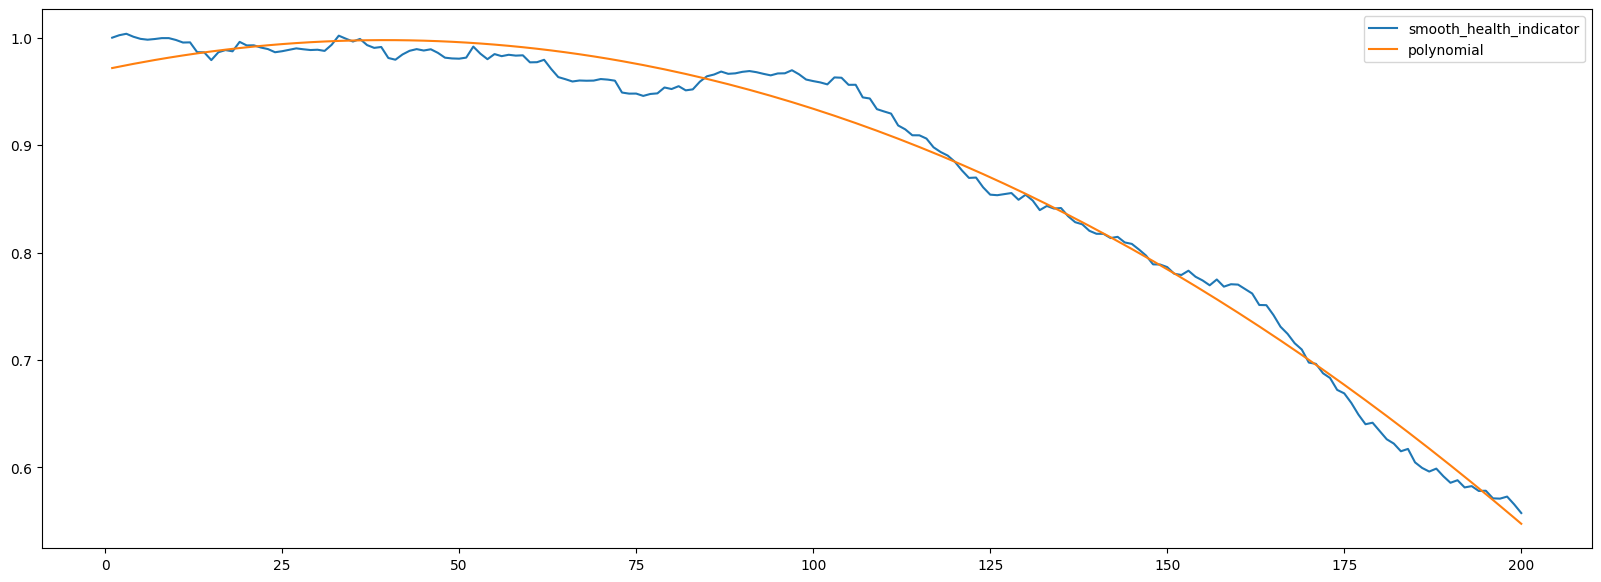

In [108]:
unit = np.random.choice(trainDataFused.Unit)
select_Unit = trainDataFused[trainDataFused.Unit == unit]
reg_model = reg_model_lib_1day[unit]
poly = PolynomialFeatures(degree=2)
line_poly = reg_model.predict(poly.fit_transform(np.arange(1, len(select_Unit)+1).reshape(-1, 1)))    

plt.figure(figsize=(20, 7))
plt.plot(select_Unit.Time, select_Unit.smooth_health_indicator, label="smooth_health_indicator")
#plt.plot(select_Unit.Time, select_Unit.health_indicator, label="health_indicator")
plt.plot(select_Unit.Time, line_poly, label = "polynomial")
plt.legend()

In [113]:
def calc_degree(fused_data, start_degree = 2, stop_degree = 21):
    
    start_degree = max(2, start_degree)
    stop_degree = max(start_degree+1, stop_degree)
    
    health_indicator = fused_data[['Unit', 'Time', 'smooth_health_indicator']].copy()
    list_reg_model = []
    print("fit model:")
    for degree in range(start_degree, stop_degree):
        reg_model_lib = fit_polyline(health_indicator, polynomial_deg=degree)
        list_reg_model.append(reg_model_lib)
    
    print("calc mse:")
    list_mse = []
    for degree in range(start_degree, stop_degree):
        mse_degree = []
        for unit in fused_data.Unit.unique():
            select_Unit = fused_data[fused_data.Unit == unit]
            reg_model = list_reg_model[degree-2][unit]
            poly = PolynomialFeatures(degree=degree)
            line_poly = reg_model.predict(poly.fit_transform(np.arange(1, len(select_Unit)+1).reshape(-1, 1)))
            mse_degree.append(mean_squared_error(line_poly, select_Unit.smooth_health_indicator))
        list_mse.append(mse_degree)
        
    for i in range(start_degree-2, stop_degree-2):
        print("degree :", i+2," sum mse: ", np.array(list_mse[i]).sum())

In [114]:
calc_degree(trainDataFused)

fit model:
calc mse:
degree : 2  sum mse:  0.10638754668046604
degree : 3  sum mse:  0.02653267183408277
degree : 4  sum mse:  0.022239686665267107
degree : 5  sum mse:  0.018885388188175867
degree : 6  sum mse:  0.015565860507946946
degree : 7  sum mse:  0.013682301607562453
degree : 8  sum mse:  0.013917932566997603
degree : 9  sum mse:  0.014314544433629105
degree : 10  sum mse:  0.016277158566286084
degree : 11  sum mse:  0.020276134887931216
degree : 12  sum mse:  0.02788704165841023
degree : 13  sum mse:  0.03880724462326726
degree : 14  sum mse:  0.053342742054004105
degree : 15  sum mse:  0.06941050159244634
degree : 16  sum mse:  0.08759137667474143
degree : 17  sum mse:  0.10740461079675039
degree : 18  sum mse:  0.12941485518702334
degree : 19  sum mse:  0.15387449266256303
degree : 20  sum mse:  0.18066928907364188


In [118]:
%%time
health_indicator = trainDataFused[['Unit', 'Time', 'smooth_health_indicator']].copy()
list_reg_model = []
for degree in  range(2,21):
    print(degree)
    reg_model_lib = fit_polyline(health_indicator, polynomial_deg=degree)
    list_reg_model.append(reg_model_lib)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
CPU times: user 1.81 s, sys: 26.3 ms, total: 1.83 s
Wall time: 1.84 s


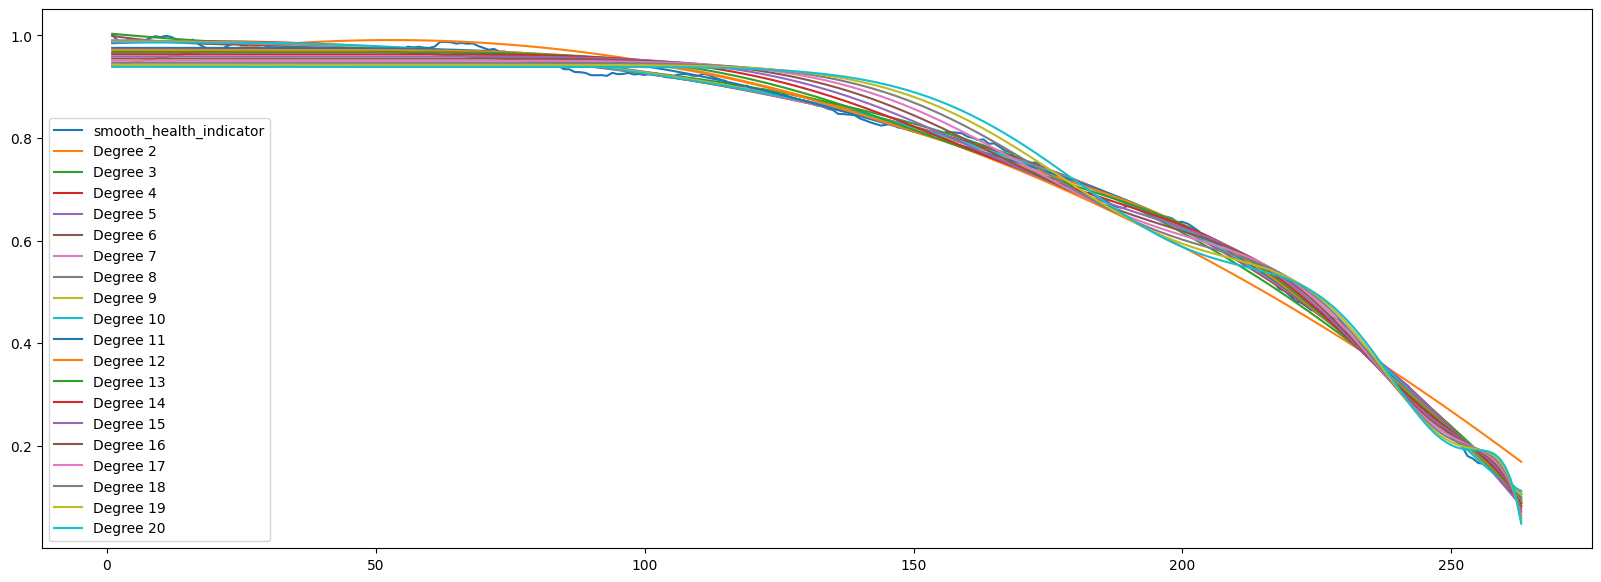

In [119]:
unit = np.random.choice(trainDataFused.Unit)
select_Unit = trainDataFused[trainDataFused.Unit == unit]

plt.figure(figsize=(20, 7))
plt.plot(select_Unit.Time, select_Unit.smooth_health_indicator, label="smooth_health_indicator")
for degree in range(2,21):
    reg_model = list_reg_model[degree-2][unit]
    poly = PolynomialFeatures(degree=degree)
    line_poly = reg_model.predict(poly.fit_transform(np.arange(1, len(select_Unit)+1).reshape(-1, 1)))    
    plt.plot(select_Unit.Time, line_poly, label = f"Degree {degree}")
plt.legend()

In [120]:
mse = mean_squared_error(line_poly,select_Unit.smooth_health_indicator)
mse

0.0015215084566750896

In [122]:
%%time
list_mse = []
for degree in range(2,21):
    print(degree)
    mse_degree = []
    for unit in trainDataFused.Unit.unique():
        select_Unit = trainDataFused[trainDataFused.Unit == unit]
        reg_model = list_reg_model[degree-2][unit]
        poly = PolynomialFeatures(degree=degree)
        line_poly = reg_model.predict(poly.fit_transform(np.arange(1, len(select_Unit)+1).reshape(-1, 1)))
        mse_degree.append(mean_squared_error(line_poly, select_Unit.smooth_health_indicator))
    list_mse.append(mse_degree)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
CPU times: user 1.04 s, sys: 12.8 ms, total: 1.05 s
Wall time: 1.05 s


In [123]:
%%time
for i in range(0, 19):
    print("degree :", i+2," sum mse: ", np.array(list_mse[i]).sum())

degree : 2  sum mse:  0.10638754668046604
degree : 3  sum mse:  0.02653267183408277
degree : 4  sum mse:  0.022239686665267107
degree : 5  sum mse:  0.018885388188175867
degree : 6  sum mse:  0.015565860507946946
degree : 7  sum mse:  0.013682301607562453
degree : 8  sum mse:  0.013917932566997603
degree : 9  sum mse:  0.014314544433629105
degree : 10  sum mse:  0.016277158566286084
degree : 11  sum mse:  0.020276134887931216
degree : 12  sum mse:  0.02788704165841023
degree : 13  sum mse:  0.03880724462326726
degree : 14  sum mse:  0.053342742054004105
degree : 15  sum mse:  0.06941050159244634
degree : 16  sum mse:  0.08759137667474143
degree : 17  sum mse:  0.10740461079675039
degree : 18  sum mse:  0.12941485518702334
degree : 19  sum mse:  0.15387449266256303
degree : 20  sum mse:  0.18066928907364188
CPU times: user 2.28 ms, sys: 1.04 ms, total: 3.32 ms
Wall time: 5.17 ms


Choose 7

## RUL using class

In [89]:
class residualSimilarityModel:
    def __init__(self):
        self.df_model = pd.DataFrame(columns = ['Unit','lifeSpan','poly'], index=None)
    
    def fit(self, dataTrain, polynomial_deg=3): # data train has many machines
        units = dataTrain.Unit.unique()
#         for unit in units:
#             each_unit = dataTrain[dataTrain.Unit == unit].copy()
#             poly = np.polyfit(each_unit.Timestep, each_unit.smooth_health_indicator, polynomial_deg) ## Poly 
#             self.df_model = self.df_model.append(pd.Series({
#                 'Unit': unit,
#                 'lifeSpan':each_unit.Timestep.values[-1],
#                 'poly':poly,
#             }), ignore_index = True)
        list_poly = []
        for unit in units:
            each_unit = dataTrain[dataTrain.Unit == unit].copy()
            poly = np.polyfit(each_unit.Timestep, each_unit.smooth_health_indicator, polynomial_deg)  ## Poly
            list_poly.append(pd.Series({
                'Unit': unit,
                'lifeSpan': each_unit.Timestep.values[-1],
                'poly': poly,
            }).to_frame().T)
        self.df_model = pd.concat(list_poly)
            
    def predictRUL(self, dataTest,NEIGHBORS_NUM=20): # data test is a machine
        list_score = []
        for poly in self.df_model.poly:
            d_ij = np.linalg.norm(dataTest.smooth_health_indicator - np.polyval(poly, dataTest.Timestep),ord=1)
            list_score.append(d_ij)
        
        df_pred = self.df_model[['Unit','lifeSpan']].copy()
        df_pred['score'] = list_score
        df_pred.sort_values(by = 'score',inplace=True)
        df_pred = df_pred[:NEIGHBORS_NUM]
        
        estRUL = df_pred.lifeSpan.mean() - dataTest.Timestep.max()
        ciRUL = [df_pred.lifeSpan.min()- dataTest.Timestep.max(),df_pred.lifeSpan.max()- dataTest.Timestep.max()]
        
        return estRUL, ciRUL, df_pred

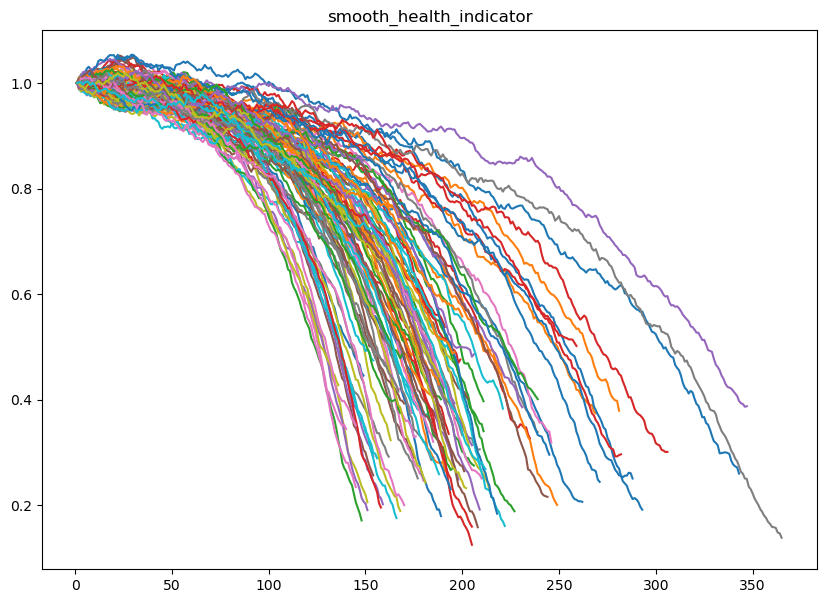

In [90]:
vis_ensemble(trainDataFused,['smooth_health_indicator'],100)

In [91]:
model = residualSimilarityModel()
model.fit(trainDataFused)

In [92]:
test = validataionDataToFused[validataionDataToFused.Unit == 176].copy()
trueRUL = test.Timestep.max()
test = test[:int(test.Timestep.max()*0.9)]
trueRUL -= test.Timestep.max()
estRUL, ciRUL, df_predict = model.predictRUL(test)
estRUL, trueRUL

(18.19999999999999, 17)

In [100]:
val_unit = validataionDataToFused[validataionDataToFused.Unit == 200].copy()
min_day_predict = 50

In [93]:
def predict_by_day(val_unit,model,min_day_predict=50):
    losses = []
    labels = []
    predict_results = []

    for i in range(len(val_unit) - int(min_day_predict)):
        sample_len = int(min_day_predict + i)

        each_day = val_unit[:sample_len]
        true_RUL = len(val_unit) - sample_len
        predict_RUL,_,_ = model.predictRUL(each_day,NEIGHBORS_NUM=20)

        predict_results.append(predict_RUL)
        losses.append(abs(predict_RUL - true_RUL))
        labels.append(true_RUL)

    return losses, labels, predict_results

In [94]:
losses, labels, predict_results = predict_by_day(val_unit, model, min_day_predict=50)

NameError: name 'val_unit' is not defined

In [97]:
def evaluate_rul(train_fused_data, val_fused_data, degree=3):
    model = residualSimilarityModel()
    model.fit(train_fused_data)
    
    loss_df = []
    label_df = []
    predict_df = []
    unit_df = []
    for unit in val_fused_data.Unit.unique():
        try:
            val_unit = val_fused_data[val_fused_data.Unit == unit].copy().reset_index(drop=True)
            losses, labels, predict_results = predict_by_day(val_unit, model, min_day_predict=50)
            
            loss_df += losses
            label_df += labels
            predict_df += predict_results
            unit_df += ([unit]*len(losses))
        except:
            print("Error unit:", unit)
            
    ans = pd.DataFrame(columns = ['Unit', 'True', 'Predict', 'Loss'])
    ans['Unit'] = unit_df
    ans['True'] = label_df
    ans['Predict'] = predict_df
    ans['Loss'] = loss_df
    return ans

In [98]:
loss_neighbor = evaluate_rul(trainDataFused, validataionDataToFused, degree=3)

<AxesSubplot:ylabel='Count'>

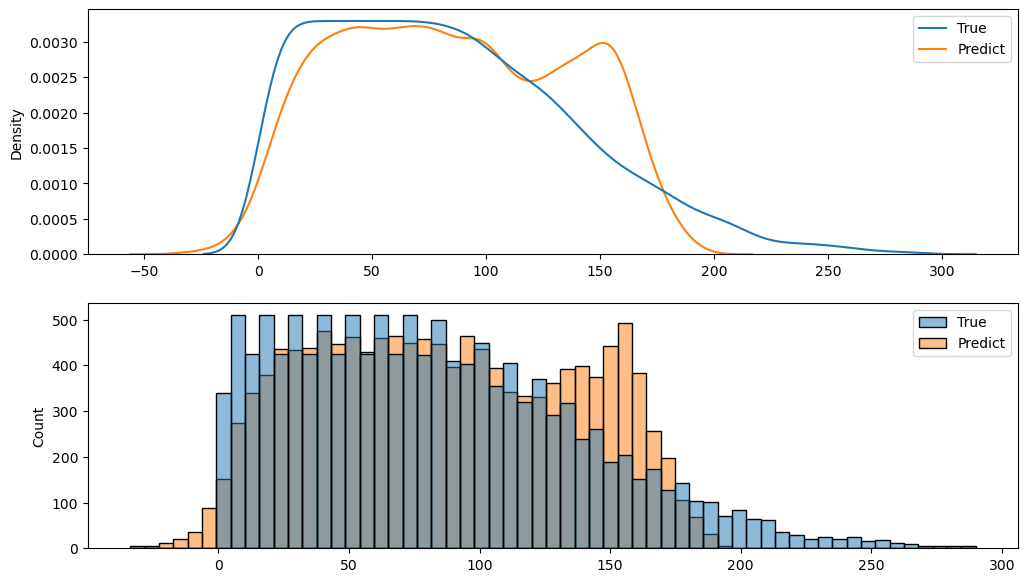

In [99]:
fig, axs = plt.subplots(2, figsize=(12,7))
sns.kdeplot(ax= axs[0], data=loss_neighbor.loc[:, ['True','Predict']])
sns.histplot(ax = axs[1], data=loss_neighbor.loc[:, ['True','Predict']])

<Axes: ylabel='Count'>

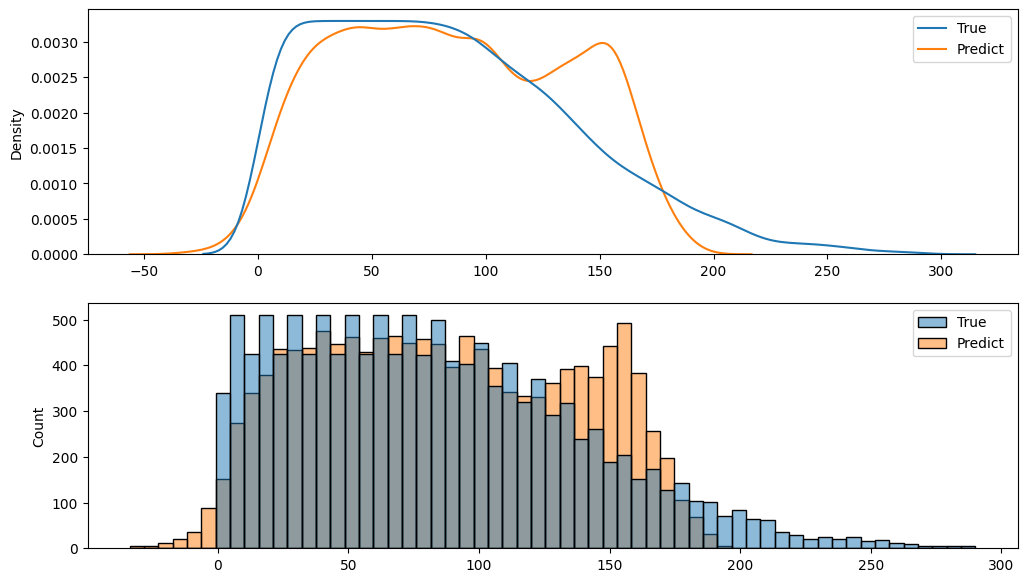

In [122]:
fig, axs = plt.subplots(2, figsize=(12,7))
sns.kdeplot(ax= axs[0], data=loss_neighbor.loc[:, ['True','Predict']])
sns.histplot(ax = axs[1], data=loss_neighbor.loc[:, ['True','Predict']])

In [130]:
loss_neighbor_was = loss_neighbor.copy()

In [134]:
loss_neighbor_was = predict_continuously(loss_neighbor_was)
make_score(loss_neighbor_was)
make_score_warning(loss_neighbor_was)

Score of all points: 0.9442678862103713
Score of warning points: 0.8144796380090498


In [44]:
polynomial_deg=3

In [56]:
dataTrain = trainDataFused.copy()

In [60]:
df_model = pd.DataFrame(columns = ['Unit','lifeSpan','poly'], index=None)
units = dataTrain.Unit.unique()
for unit in units:
    each_unit = dataTrain[dataTrain.Unit == unit].copy()
    poly = np.polyfit(each_unit.Timestep, each_unit.smooth_health_indicator, polynomial_deg) ## Poly 
    df_model = df_model.append(pd.Series({
        'Unit': unit,
        'lifeSpan':each_unit.Timestep.values[-1],
        'poly':poly,
    }), ignore_index = True)

In [61]:
df_model

,Unit,lifeSpan,poly
0,1,149,"[-2.4859496187333356e-07, 1.6419131258084303e-..."
1,2,269,"[-3.347661218705392e-08, 2.2939499303382285e-0..."
2,3,206,"[-1.4536118249082907e-07, 1.769105051476088e-0..."
3,4,235,"[-1.1170964107538254e-07, 2.2118458733634294e-..."
4,5,154,"[-3.5511673146515695e-07, 3.633174452347242e-0..."
...,...,...,...
170,171,258,"[-5.437058107979067e-08, 4.8533782836102534e-0..."
171,172,174,"[-2.293704462465025e-07, 3.5983941402001096e-0..."
172,173,151,"[-3.504179050812116e-07, 2.6377368838715326e-0..."
173,174,193,"[-9.558951611957116e-08, 7.900305265929304e-06..."


In [83]:
df_model = pd.DataFrame(columns = ['Unit','lifeSpan','poly'], index=None)
units = dataTrain.Unit.unique()
list_poly = []
for unit in units:
    each_unit = dataTrain[dataTrain.Unit == unit].copy()
    poly = np.polyfit(each_unit.Timestep, each_unit.smooth_health_indicator, polynomial_deg)  ## Poly
    list_poly.append(pd.Series({
        'Unit': unit,
        'lifeSpan': each_unit.Timestep.values[-1],
        'poly': poly,
    }).to_frame().T)
df_model = pd.concat(list_poly)

In [84]:
df_model

,Unit,lifeSpan,poly
0,1,149,"[-2.4859496187333356e-07, 1.6419131258084303e-..."
0,2,269,"[-3.347661218705392e-08, 2.2939499303382285e-0..."
0,3,206,"[-1.4536118249082907e-07, 1.769105051476088e-0..."
0,4,235,"[-1.1170964107538254e-07, 2.2118458733634294e-..."
0,5,154,"[-3.5511673146515695e-07, 3.633174452347242e-0..."
...,...,...,...
0,171,258,"[-5.437058107979067e-08, 4.8533782836102534e-0..."
0,172,174,"[-2.293704462465025e-07, 3.5983941402001096e-0..."
0,173,151,"[-3.504179050812116e-07, 2.6377368838715326e-0..."
0,174,193,"[-9.558951611957116e-08, 7.900305265929304e-06..."
